# TUTORIAL 1: Serpent, Cerberus and criticality

## 1) Initializing Serpent from Python with Cerberus

In [1]:
# Import modules
from cerberus.solvers import CodeInput, Solver
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon, Circle
import pandas as pd

In [2]:
# Input
list_input_files = ['input'] # list all file paths used in Serpent 
serpent_path = '/home/yvrob/Serpent_Cerberus/Serpent_2.2.0_pbed/sss2'
ncores = 20 # how many cores to use with openmpi

In [3]:
# Create serpent instance
serpent = Solver("Serpent", serpent_path, f"-port -omp {ncores}".split()) # port is for telling Serpent it is coupled with Cerberus
serpent.input = CodeInput(list_input_files, main_input_idx=0) # first ("0") input file is the main file

In [4]:
# Start Serpent. It will not run transport, just create materials/geometry, import cross sections, plot, etc.
# Cerberus will create a working directory named "wrk_Serpent", where the output will be copied and run safely.
serpent.initialize()

# It prints the output and input variables, the type of data expected to send/receive, and number of values for each variable

Creating working directory and input for Serpent...
OK.
Initializing Serpent for socket communication
OK.
Obtaining field names and variable definitions for Serpent
Solver Serpent can accept 0 fields:

Solver Serpent can provide 0 fields:

Solver Serpent can provide 353 variable(s):
Name                                               Data Type  Number of Values    
sss_ov_DET_detlatfuel                              float64    49                  
sss_ov_DET_detlatfuel_rel_unc                      float64    49                  
sss_ov_DET_EnergyDetector                          float64    500                 
sss_ov_DET_EnergyDetector_rel_unc                  float64    500                 
sss_ov_DET_EnergyDetectorfuel                      float64    500                 
sss_ov_DET_EnergyDetectorfuel_rel_unc              float64    500                 
sss_ov_DET_EnergyDetectorgraf                      float64    500                 
sss_ov_DET_EnergyDetectorgraf_rel_unc              f

In [5]:
# The output should show the different input "sss_iv" and output "sss_ov" options available
# You can list them or find "transferrables":
print([i.split('sss_ov_')[-1] for i in serpent.output_variable_names if 'fuel_salt_' in i]) # all output (Serpent->Python) info that can be monitored for the fuel_salt material
print([i.split('sss_iv_')[-1] for i in serpent.input_variable_names if 'fuel_salt_' in i]) # all input (Python->Serpent) info that can be controlled for the fuel_salt material
# "material" usually refers to material-wise information, e.g material_fuel_salt_adens gives material atomic density
# "composition" usually refers to nuclide-wise information, e.g composition_fuel_salt_adens gives atomic density vector



['material_fuel_salt_adens', 'material_fuel_salt_mdens', 'material_fuel_salt_burnable', 'material_fuel_salt_volume', 'material_fuel_salt_burnup', 'material_fuel_salt_fima', 'composition_fuel_salt_nuclides', 'composition_fuel_salt_zai', 'composition_fuel_salt_adens', 'composition_fuel_salt_original', 'composition_fuel_salt_inventory']
['composition_fuel_salt_adens', 'material_fuel_salt_volume', 'material_fuel_salt_color', 'material_fuel_salt_burnable', 'material_fuel_salt_decay', 'material_fuel_salt_burn', 'material_fuel_salt_burnup']


## 2) Accessing data in Serpent

In [6]:
# Try to access transferrable in Serpent from its name, here the power in the reactor
current_transferrable = serpent.get_transferrable('sss_ov_norm_power')
# Ask Serpent to send the corresponding information, "communicate"
current_transferrable.communicate()
# Now the transferrable is filled with values in value_vec. Here only one value corresponding to the power
print(current_transferrable.value_vec)

[250000.]


In [7]:
# We can also print all the information contained in a transferrable
current_transferrable.__dict__

{'_comm': <cerberus.communicators.SocketCommunicator at 0x7ffaa4277130>,
 'name': 'sss_ov_norm_power',
 'iteration': 0,
 'n_values': 1,
 'values_set': False,
 'value_vec': array([250000.]),
 'value_vec_prev': array([nan]),
 'dtype': dtype('float64'),
 'is_initialized': True,
 '_max_abs_diff': 1e+20,
 '_max_rel_diff': 1e+20,
 '_l2_abs': 0.0,
 '_l2_rel': 0.0}

In [8]:
# Input variables, setting values
# Simple example: when communicating a value of 1 for "sss_iv_plot_geometry", asks Serpent to re-plot the current plots.
current_transferrable = serpent.get_transferrable('sss_iv_plot_geometry')

# Set value to 1. Warning: Serpent does not know yet this information! It will just plot whenever you communicate.
current_transferrable.value_vec = np.array([1]) # always a numpy array
# or
# current_transferrable.value_vec[0] = 1

# It should just overwrite the files as they already exist, so let's rename them first
shutil.move('./wrk_Serpent/input_geom1.png', './wrk_Serpent/input_geom1_original.png')
shutil.move('./wrk_Serpent/input_geom2.png', './wrk_Serpent/input_geom2_original.png')

# Communicate, now Serpent will receive a signal and plot the geometry
current_transferrable.communicate()
# Now check the wrk_Serpent directory and see if you have 4 files: 2 originals that we moved, 2 that we made Serpent create

In [9]:
# To make our life easier, we can create a routine that does the "get_transferrable" and "communicate" together.
def get_values(name, serpent_instance, input_variable=False):
    if input_variable and 'sss_iv_' not in name: # you can get rid of "sss_ov" from now on
        transferrable_name = 'sss_iv_'+name
    else:
        transferrable_name = 'sss_ov_'+name
    transferrable = serpent_instance.get_transferrable(transferrable_name)
    if not input_variable: # we should NOT communicate this when just monitoring input variables, Serpent does not know this information
        transferrable.communicate() # receive
    return transferrable

# For input variables, we can set values of value_vec
def set_values(name, values, serpent_instance): # you can only set input variables so no need to use sss_ov
    if 'sss_iv_' not in name: # you can get rid of "sss_ov" from now on
        transferrable_name = 'sss_iv_'+name
    transferrable = serpent_instance.get_transferrable(transferrable_name)
    transferrable.value_vec = np.array(values)
    transferrable.communicate() # send
    return transferrable

In [10]:
# Print list of materials
print('List of materials:', get_values('materials', serpent).value_vec) # "sss_ov_materials"

# Let's get all the information (sss_ov) about the fuel_salt material
print('\nList of output parameters for material "fuel_salt":')
for name in [i.split('sss_ov_')[-1] for i in serpent.output_variable_names if 'fuel_salt_' in i]:
    print('\t- ', name, get_values(name, serpent).value_vec) # Output variables

# Same for input: what we can control
# Let's get all the information (sss_ov) about the fuel_salt material
print('\nList of input parameters for material "fuel_salt":')
for name in [i.split('sss_iv_')[-1] for i in serpent.input_variable_names if 'fuel_salt_' in i]:
    print('\t- ', name, get_values(name, serpent, input_variable=True).value_vec) # Input variables
# As you can see the values for input variables are zeros because we would need to control it and communicate it to make it change in Serpent

List of materials: ['fuel_salt' 'fuel_salt2' 'updown' 'hastalloy' 'graphite' 'B4C' 'ssteel'
 'nit']

List of output parameters for material "fuel_salt":
	-  material_fuel_salt_adens [0.0757365]
	-  material_fuel_salt_mdens [2.1286]
	-  material_fuel_salt_burnable [1]
	-  material_fuel_salt_volume [179070.78125462]
	-  material_fuel_salt_burnup [0.]
	-  material_fuel_salt_fima [0.]
	-  composition_fuel_salt_nuclides ['92235.06c' '92238.06c' '9019.06c' '3007.06c' '4009.06c' '40000.06c']
	-  composition_fuel_salt_zai [922350 922380  90190  30070  40090 400000]
	-  composition_fuel_salt_adens [4.55707864e-05 2.30615798e-04 4.50491006e-02 1.99468089e-02
 8.93003289e-03 1.53436991e-03]
	-  composition_fuel_salt_original [4.55707864e-05 2.30615798e-04 4.50491006e-02 1.99468089e-02
 8.93003289e-03 1.53436991e-03]
	-  composition_fuel_salt_inventory []

List of input parameters for material "fuel_salt":
	-  composition_fuel_salt_adens [0. 0. 0. 0. 0. 0.]
	-  material_fuel_salt_volume [0.]
	-  m

/home/yvrob/Serpent_Cerberus/Cerberus/cerberus/variables.py:408: RuntimeWarning: invalid value encountered in double_scalars
  self._l2_abs = l2_abs/np.sqrt(n_val)
/home/yvrob/Serpent_Cerberus/Cerberus/cerberus/variables.py:409: RuntimeWarning: invalid value encountered in double_scalars
  self._l2_rel = l2_rel/np.sqrt(n_val)


## 3) Run Serpent transport

In [11]:
# Let's run a first step

# But first we can change the neutrons population to 200 here instead of changing the input
neutrons = 200
set_values('neutrons_per_cycle', [neutrons], serpent)

# Solve with these 200 neutrons
serpent.solve() # Simply run transport once

# Once this is done, we can extract the keff and its uncertainty
keff = get_values('ANA_KEFF', serpent).value_vec
keff_rel_unc = get_values('ANA_KEFF_rel_unc', serpent).value_vec
keff_unc = keff*keff_rel_unc
print(keff, keff_rel_unc, keff_unc) # 3 values each, because there is total, prompt and delayed neutrons information
print(f'keff = {keff[0]:.5f} +/- {keff_unc[0]*1e5:.0f} pcm')


[0.98750829 0.98237057 0.00556692] [0.00630187 0.00621915 0.08862069] [0.00622314 0.00610951 0.00049334]
keff = 0.98751 +/- 622 pcm


In [12]:
# The uncertainty on keff is too large, we would like ~200 pcm uncertainty
# We know that keff uncertainty scales like sqrt(N_neutrons) so we change it and rerun it, without restarting Serpent

# Calculate right number of neutrons
target_unc = 200e-5 # pcm = 1e-5
target_neutrons = int(neutrons / (target_unc/keff_unc[0])**2)
print(f'Should use ~{target_neutrons} neutrons')

# Run with new number of neutrons
set_values('neutrons_per_cycle', [target_neutrons], serpent)
serpent.solve()
keff = get_values('ANA_KEFF', serpent).value_vec
keff_rel_unc = get_values('ANA_KEFF_rel_unc', serpent).value_vec
keff_unc = keff*keff_rel_unc
print(f'keff = {keff[0]:.5f} +/- {keff_unc[0]*1e5:.0f} pcm')


Should use ~1936
keff = 1.00042 +/- 180 pcm


## 4) Detectors reading and plotting

In [13]:
# Print all detectors
detectors_list = [name.split('sss_ov_DET_')[-1] for name in serpent.output_variable_names if 'DET_' in name and '_rel_unc' not in name]
print('List of detectors:', detectors_list)

# There was a detector for the lattice in the geometry (power), we can see what is inside
detector_values = get_values('DET_detlatfuel', serpent).value_vec
detector_rel_unc = get_values('DET_detlatfuel_rel_unc', serpent).value_vec

# Shape the detector like the "lat" command says in Serpent, and hexagonal
nrows = 7
detector_values = detector_values.reshape(nrows, -1) # will get other dimension (=7 here)
# Same with uncertainties
detector_rel_unc = detector_rel_unc.reshape(nrows, -1) # will get other dimension (=7 here)

# Print
pd.DataFrame(detector_values.round(2))

List of detectors: ['detlatfuel', 'EnergyDetector', 'EnergyDetectorfuel', 'EnergyDetectorgraf', 'EnergyDetectordowncom']


,0,1,2,3,4,5,6
0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
1,0.0,0.00,0.00,6095.06,6500.06,6192.85,0.0
2,0.0,0.00,6371.99,6892.20,6924.10,6428.08,0.0
3,0.0,6158.85,6859.10,7447.58,6979.03,6225.16,0.0
4,0.0,6355.88,6988.98,7007.45,6497.46,0.00,0.0
5,0.0,6154.68,6539.43,6392.18,0.00,0.00,0.0
6,0.0,0.00,0.00,0.00,0.00,0.00,0.0


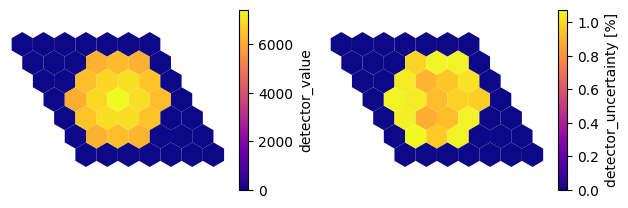

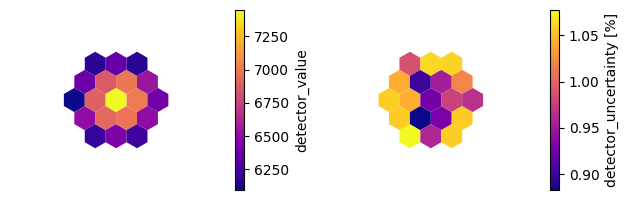

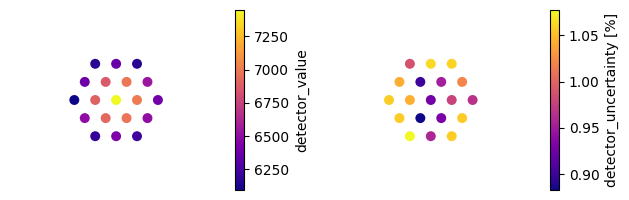

In [14]:
# Function to plot hexagonal lattice
def plot_hex(hexagonal_data, radius_over_pitch=None, hide_zeros=False, label=None): # if we give rod radii, it will render circles and not hexagons in the hexagonal lattice
    h = 1/2
    a = 2/np.sqrt(3)*h
    x0 = -3/2*h*(hexagonal_data.shape[1]-1)
    y0 = 1.5*a*(hexagonal_data.shape[1]-1)/2
    coordinates = [[], []]     
    for ind_line in range(hexagonal_data.shape[0]):
        coordinates[0].append([])
        coordinates[1].append([])
        x_inc = x0 + h*2 * ind_line
        y_inc = y0
        for ind_col in range(hexagonal_data.shape[1]):
            coordinates[0][-1].append(x_inc)
            coordinates[1][-1].append(y_inc)
            x_inc += h
            y_inc -= a*1.5

    patches = []
    array = []
    for ind_line in range(hexagonal_data.shape[0]):
        for ind_col in range(hexagonal_data.shape[1]):
            if not hide_zeros or hexagonal_data[ind_line, ind_col] != 0:
                if not radius_over_pitch: # Make hexagon
                    patches.append(RegularPolygon((coordinates[0][ind_line][ind_col], coordinates[1][ind_line][ind_col]), 6, radius=a, orientation=0, edgecolor='k'))
                else:
                    patches.append(Circle((coordinates[0][ind_line][ind_col], coordinates[1][ind_line][ind_col]), radius=radius_over_pitch))
                array.append(hexagonal_data[ind_line, ind_col])
    p = PatchCollection(patches, cmap='plasma')
    p.set_array(array)
    plt.gca().add_collection(p)
    plt.gca().axis(False)
    plt.gcf().colorbar(p, shrink=0.4, label=label)
    # Set x and y limits
    x_min, x_max = np.min(coordinates[0])-a, np.max(coordinates[0])+a
    y_min, y_max = np.min(coordinates[1])-a, np.max(coordinates[1])+a
    plt.gca().set_xlim(x_min, x_max)
    plt.gca().set_ylim(y_min, y_max)
    plt.gca().set_aspect('equal')
    plt.tight_layout()

# Plot values
fig, axs = plt.subplots(1,2)
plt.sca(ax=axs[0])
plot_hex(detector_values, hide_zeros=False, label='detector_value')
plt.sca(ax=axs[1])
plot_hex(detector_rel_unc*100, hide_zeros=False, label='detector_uncertainty [%]')

# Plot values, remove zero values
fig, axs = plt.subplots(1,2)
plt.sca(ax=axs[0])
plot_hex(detector_values, hide_zeros=True, label='detector_value')
plt.sca(ax=axs[1])
plot_hex(detector_rel_unc*100, hide_zeros=True, label='detector_uncertainty [%]')

# Plot values, remove zero values and plot as pins
fig, axs = plt.subplots(1,2)
plt.sca(ax=axs[0])
plot_hex(detector_values, radius_over_pitch=5/21, hide_zeros=True, label='detector_value')
plt.sca(ax=axs[1])
plot_hex(detector_rel_unc*100, radius_over_pitch=5/21, hide_zeros=True, label='detector_uncertainty [%]')



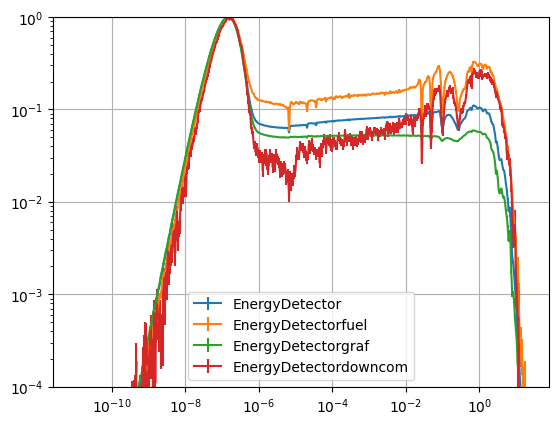

In [15]:
# Other detectors were the energy grid detector

# Reproduce energy grid (maybe in future update as a transferable?): ene MyEnergyGrid 3 500 1e-11 2e1
Egrid = np.logspace(np.log2(1e-11), np.log2(2e1), 500+1, base=2) # equal lethargy -> ln
midE = (Egrid[1:]+Egrid[:-1])/2 # take middle of energy bins

for name in ['EnergyDetector', 'EnergyDetectorfuel', 'EnergyDetectorgraf', 'EnergyDetectordowncom']:
    values = get_values("DET_"+name, serpent).value_vec # read from Serpent
    values /= values.max() # normalize
    rel_unc = get_values("DET_"+name+'_rel_unc', serpent).value_vec # read relative uncertainty from Serpent
    plt.errorbar(midE, values, yerr=rel_unc*values, label=name) 
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4, 1])
plt.gca().set_axisbelow(True)
plt.legend()